# Pseudo-bulk functional analysis

When cell lineage is clear (there are clear cell identity clusters), it might be beneficial to perform functional analyses at the pseudo-bulk level instead of the single-cell.
By doing so, we recover lowly expressed genes that before where affected by the "drop-out" effect of single-cell. 
Additionaly, if there is more than one condition in our data, we can perform differential expression analysis (DEA) and use the gene statistics as input for enrichment analysis.

In this notebook we showcase how to use `decoupler` for pathway and transcription factor (TF) enrichment from a human data-set. The data consists of ~5k Blood myeloid cells from healthy and COVID-19 infected patients available in the Single Cell Expression Atlas [here](https://www.ebi.ac.uk/gxa/sc/experiments/E-MTAB-9221/results?plotType=umap&plotOption=20).

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>  

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd

## Loading the data

We can download the data easily using `scanpy`:

In [2]:
# Download data-set 
adata = sc.datasets.ebi_expression_atlas("E-MTAB-9221", filter_boring=True)

# Rename meta-data
columns = ['Sample Characteristic[sex]',
           'Sample Characteristic[individual]',
           'Sample Characteristic[disease]',
           'Factor Value[inferred cell type - ontology labels]']
adata.obs = adata.obs[columns]
adata.obs.columns = ['sex','individual','disease','cell_type']
adata

AnnData object with n_obs × n_vars = 6178 × 18958
    obs: 'sex', 'individual', 'disease', 'cell_type'

## Processing

This specific data-set contains ensmbl gene ids instead of gene symbols. 
To be able to use `decoupler` we need to transform them into gene symbols:

In [3]:
# Retrieve gene symbols
annot = sc.queries.biomart_annotations("hsapiens",
        ["ensembl_gene_id", "external_gene_name"],
    ).set_index("ensembl_gene_id")

# Filter genes not in annotation
adata = adata[:, adata.var.index.intersection(annot.index)]

# Assign gene symbols
adata.var['gene_symbol'] = [annot.loc[ensembl_id,'external_gene_name'] for ensembl_id in adata.var.index]
adata.var = adata.var.reset_index().rename(columns={'index': 'ensembl_gene_id'}).set_index('gene_symbol')

# Remove genes with no gene symbol
adata = adata[:, ~pd.isnull(adata.var.index)]

# Remove duplicates
adata.var_names_make_unique()

/tmp/ipykernel_10627/3777209676.py:10: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_symbol'] = [annot.loc[ensembl_id,'external_gene_name'] for ensembl_id in adata.var.index]
/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Since the meta-data of this data-set is available, we can filter cells that were not annotated:

In [4]:
# Remove non-annotated cells
adata = adata[~adata.obs['cell_type'].isnull()]

We will store the raw counts in the `.layers` attribute so that we can use them
afterwards to generate pseudo-bulk profiles.

In [5]:
# Store raw counts in layers
adata.X = np.round(adata.X)
adata.layers['counts'] = adata.X

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['normalized'] = adata.X

We can also look how cells cluster by cell identity:

/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:4

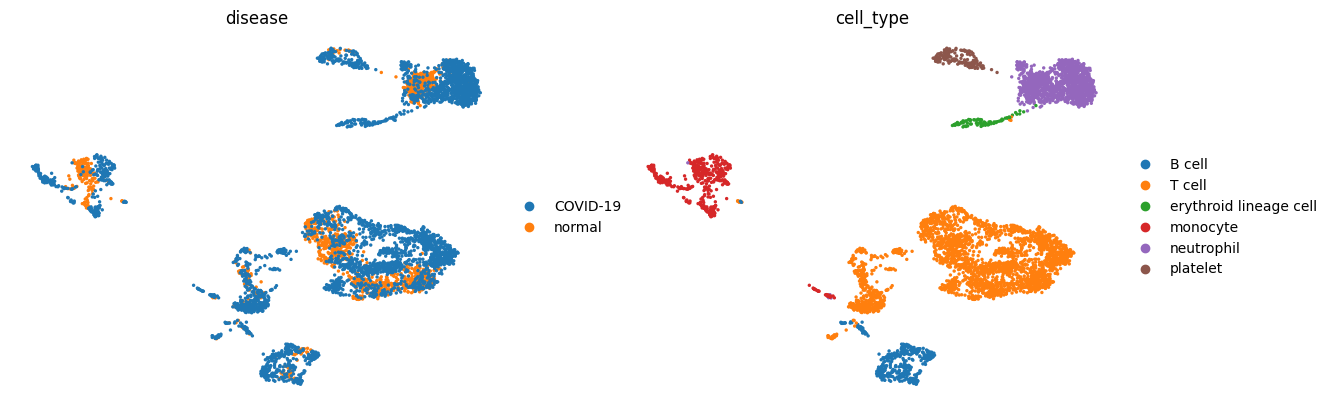

In [6]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, batch_key='individual')

# Scale the data
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata)

# Generate UMAP features
sc.tl.umap(adata)

# Visualize
sc.pl.umap(adata, color=['disease','cell_type'], frameon=False)

In this data-set we have two condition, `COVID-19` and `healthy`, across 6 different cell types.

## Generation of pseudo-bulk profiles

After the annotation of clusters into cell identities, we often would like to perform differential expression analysis (DEA) between conditions within particular cell types to further characterize them. DEA can be performed at the single-cell level, but the obtained p-values are often inflated as each cell is treated as a sample. We know that single cells within a sample are not independent of each other, since they were isolated from the same environment. If we treat cells as samples, we are not testing the variation across a population of samples, rather the variation inside an individual one. Moreover, if a sample has more cells than another it might bias the results. 

The current best practice to correct for this is using a pseudo-bulk approach ([Squair J.W., et al 2021](https://doi.org/10.1038/s41467-021-25960-2)), which involves the following steps:

1. Subsetting the cell type(s) of interest to perform DEA.
2. Extracting their raw integer counts.
3. Summing their counts per gene into a single profile if they pass quality control.
4. Performing DEA if at least two biological replicates per condition are available (more replicates are recommended).

We can pseudobulk using the function `decoupler.get_pseudobulk`. In this example, we are interested in summing the counts but other
modes are available, for more information check its argument `mode`.

In [7]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(adata,
                          sample_col='individual',
                          groups_col='cell_type',
                          layer='counts',
                          mode='sum',
                          min_cells=0,
                          min_counts=0
                         )
pdata

AnnData object with n_obs × n_vars = 38 × 17307
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

It has generated a profile for each sample and cell type. We can plot their quality control metrics:

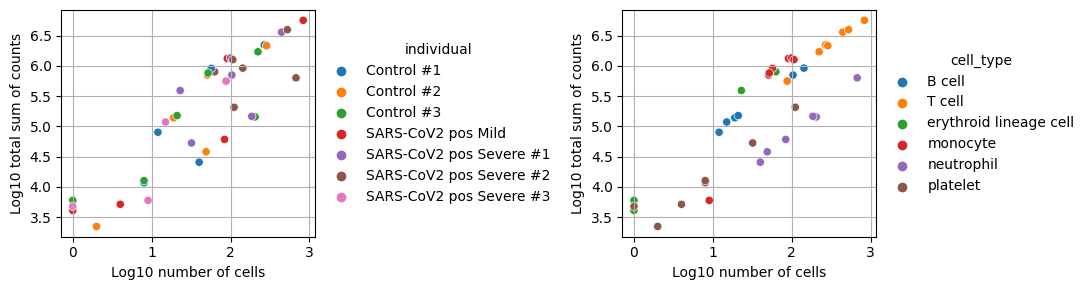

In [8]:
dc.plot_psbulk_samples(pdata, groupby=['individual', 'cell_type'], figsize=(11, 3))

There are two criteria to filter low quality samples: its number of cells (`psbulk_n_cells`), and its total sum of counts (`psbulk_counts`).
In these plots it can be seen that there are some samples of platelet cells that contain less than 10 cells, we might want to remove
them by using the arguments `min_cells` and `min_counts`. Note that these thresholds are arbitrary and will change depening on the
dataset, but a good rule of thumb is to have at least 10 cells with 1000 accumulated counts.

In [9]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(adata,
                          sample_col='individual',
                          groups_col='cell_type',
                          layer='counts',
                          mode='sum',
                          min_cells=10,
                          min_counts=1000
                         )
pdata

AnnData object with n_obs × n_vars = 30 × 17306
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

Additionally to filtering low quality samples, we can also filter noisy expressed genes in case we want to perform downstream analyses such as DEA afterwards. Note that this step should be done at the cell type level, since each cell type may express different collection of genes.

For this vignette, we will explore the effects of COVID on T cells. Let's first select our samples of interest:

In [10]:
# Select T cell profiles
tcells = pdata[pdata.obs['cell_type'] == 'T cell'].copy()

To filter genes, we will follow the strategy implemented in the function `filterByExpr` from [edgeR](https://rdrr.io/bioc/edgeR/man/filterByExpr.html).
It keeps genes that have a minimum total number of reads across samples (`min_total_count`), and that have a minimum number of counts in a number of samples (`min_count`).

We can plot how many genes do we keep, you can play with the `min_count` and `min_total_count` to check how many genes would be kept when changed:

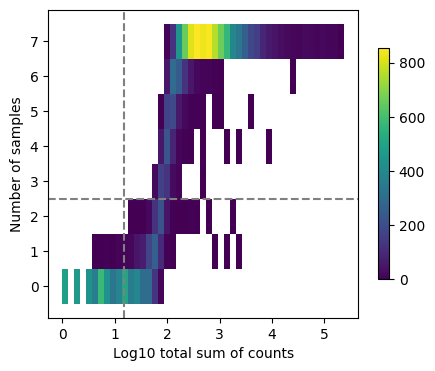

In [11]:
dc.plot_filter_by_expr(tcells, group='disease', min_count=10, min_total_count=15)

Here we can observe the frequency of genes with different total sum of counts and number of samples. With the default values
we would keep a good quantity of genes while filtering potential noisy genes.

Once we are content with the threshold parameters, we can perform the actual filtering:

In [12]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(tcells, group='disease', min_count=10, min_total_count=15)

# Filter by these genes
tcells = tcells[:, genes].copy()
tcells

AnnData object with n_obs × n_vars = 7 × 10240
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

Another filtering strategy is to filter out genes that are not expressed in a percentage of cells and samples, as implemented
in `decoupler.filter_by_prop`.

## Contrast between conditions
Once we have generated robust pseudo-bulk profiles, we can compute DEA. For this example, we will perform a simple
experimental design where we compare the gene expression of T cells from diseased patients against controls. We will use the
python implementation of the framework DESeq2, but we could have used any other one (`limma` or `edgeR` for example).
For a better understanding how it works, check [DESeq2's documentation](https://pydeseq2.readthedocs.io/en/latest/). Note that
more complex experimental designs can be used by adding more factors to the `design_factors` argument.

In [13]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [14]:
# Build DESeq2 object
dds = DeseqDataSet(
    adata=tcells,
    design_factors='disease',
    refit_cooks=True,
    n_cpus=8,
)

In [15]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 30.65 seconds.

Fitting dispersion trend curve...
... done in 4.13 seconds.

Fitting MAP dispersions...
... done in 37.50 seconds.

Fitting LFCs...
... done in 2.27 seconds.

Refitting 0 outliers.



In [16]:
# Extract contrast between COVID-19 vs normal
stat_res = DeseqStats(dds, contrast=["disease", 'COVID-19', 'normal'], n_cpus=8)

In [17]:
# Compute Wald test
stat_res.summary()

Running Wald tests...
... done in 1.12 seconds.

Log2 fold change & Wald test p-value: disease COVID-19 vs normal


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
A1BG,76.991470,-0.153057,0.131288,-1.165814,0.243690,0.591482
A2M,36.823917,-1.264598,0.332496,-3.803349,0.000143,0.006928
A2MP1,16.824497,0.408382,0.786223,0.519423,0.603466,0.850168
AAAS,19.126410,0.224634,0.375065,0.598921,0.549225,0.821362
AACS,27.160725,0.309975,0.235435,1.316603,0.187972,0.531902
...,...,...,...,...,...,...
ZXDC,30.410732,-0.319285,0.324553,-0.983769,0.325229,0.664150
ZYG11B,111.220726,0.238652,0.293449,0.813268,0.416065,0.736324
ZYX,83.023331,0.317867,0.239164,1.329077,0.183823,0.525560


In [18]:
# Shrink LFCs
stat_res.lfc_shrink()

Fitting MAP LFCs...
... done in 5.34 seconds.

Shrunk Log2 fold change & Wald test p-value: disease COVID-19 vs normal


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
A1BG,76.991470,-0.106114,0.124962,-1.165814,0.243690,0.591482
A2M,36.823917,-1.070022,0.344580,-3.803349,0.000143,0.006928
A2MP1,16.824497,0.019933,0.274213,0.519423,0.603466,0.850168
AAAS,19.126410,0.042727,0.235336,0.598921,0.549225,0.821362
AACS,27.160725,0.133268,0.207973,1.316603,0.187972,0.531902
...,...,...,...,...,...,...
ZXDC,30.410732,-0.079607,0.224870,-0.983769,0.325229,0.664150
ZYG11B,111.220726,0.067651,0.214385,0.813268,0.416065,0.736324
ZYX,83.023331,0.131753,0.209261,1.329077,0.183823,0.525560


In [19]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
A1BG,76.991470,-0.106114,0.124962,-1.165814,0.243690,0.591482
A2M,36.823917,-1.070022,0.344580,-3.803349,0.000143,0.006928
A2MP1,16.824497,0.019933,0.274213,0.519423,0.603466,0.850168
AAAS,19.126410,0.042727,0.235336,0.598921,0.549225,0.821362
AACS,27.160725,0.133268,0.207973,1.316603,0.187972,0.531902
...,...,...,...,...,...,...
ZXDC,30.410732,-0.079607,0.224870,-0.983769,0.325229,0.664150
ZYG11B,111.220726,0.067651,0.214385,0.813268,0.416065,0.736324
ZYX,83.023331,0.131753,0.209261,1.329077,0.183823,0.525560


We can plot the obtained results in a volcano plot:

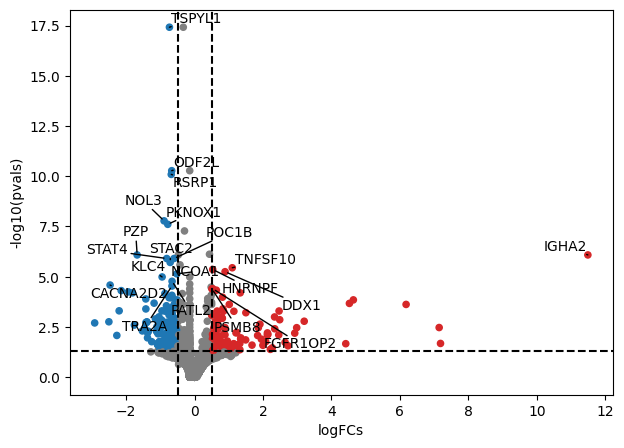

In [20]:
dc.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=20)

After performing DEA, we can use the obtained gene level statistics to perform enrichment analysis. Any statistic can be used,
but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value.
We will transform the obtained t-values stored in `stats` to a wide matrix so that it can be used by `decoupler`:

In [21]:
mat = results_df[['stat']].T.rename(index={'stat': 'T cell'})
mat

gene_symbol,A1BG,A2M,A2MP1,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZUP1,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
T cell,-1.165814,-3.803349,0.519423,0.598921,1.316603,-0.077919,-0.630326,0.258907,1.468314,-0.45507,...,1.647822,1.350167,3.066929,-1.187877,-3.314286,-0.983769,0.813268,1.329077,0.078577,-0.295966


## Pathway activity inference
To estimate pathway activities we will use the resource PROGENy and the `consensus` method.

For another example on pathway activities please visit this other notebook: [Pathway activity inference](https://decoupler-py.readthedocs.io/en/latest/notebooks/progeny.html).

In [22]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=300)

# Infer pathway activities with consensus
pathway_acts, pathway_pvals = dc.run_consensus(mat=mat, net=progeny)
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
T cell,-0.028509,0.160006,0.291125,-1.387576,1.867857,-0.994964,-1.993261,-0.025847,-0.620179,-0.933021,0.426028,-0.085228,-0.028253,-0.535037


Let us plot the obtained scores:

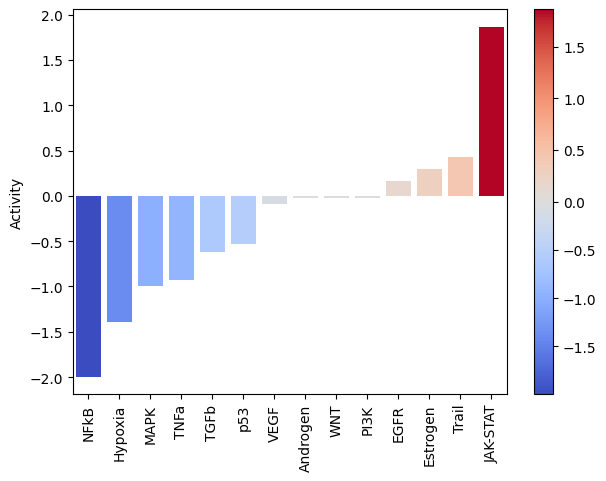

In [23]:
dc.plot_barplot(pathway_acts, 'T cell', top=25, vertical=False)

It looks like JAK-STAT, a known immunity pathway is more active in T cells from COVID-19 patients than in controls. To further explore how the target genes of a pathway of interest behave, we can plot them in scatter plot:

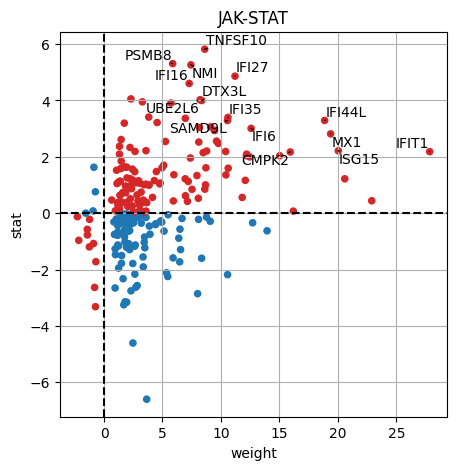

In [24]:
dc.plot_targets(results_df, stat='stat', source_name='JAK-STAT', net=progeny, top=15)

The observed activation of JAK-STAT is due to the fact that majority of its target genes with positive weights have positive
t-values (1st quadrant), and the majority of the ones with negative weights have negative t-values (3d quadrant).

## Transcription factor activity inference
Similarly to pathways, we can estimate transcription factor activities using the resource DoRothEA and the `consensus` method.

For another example on transcription factor activities please visit this other notebook: [Transcription factor activity inference](https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html).

In [25]:
# Retrieve DoRothEA gene regulatory network
dorothea = dc.get_dorothea()

# Infer pathway activities with consensus
tf_acts, tf_pvals = dc.run_consensus(mat=mat, net=dorothea)
tf_acts

,AHR,AR,ARID2,ARID3A,ARNT,ARNTL,ASCL1,ATF1,ATF2,ATF3,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
T cell,-0.292416,0.556405,-1.642831,-0.354112,0.399863,-1.400182,-1.67815,-0.829347,-1.467637,-0.36772,...,-0.080463,-0.380974,-2.050737,-0.407244,-1.329976,-0.100465,-1.233004,-0.560112,-1.120935,-1.200713


Let us plot the obtained scores for the top active/inactive transcription factors:

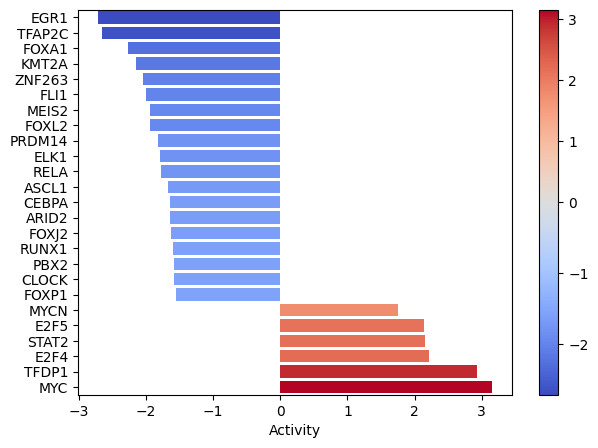

In [26]:
dc.plot_barplot(tf_acts, 'T cell', top=25, vertical=True)

In accordance to the previous pathway results, T cells seem to activate the transcription factor STAT2, a member of the JAK-STAT pathway.

Like with pathways, we can explore how the target genes look like:

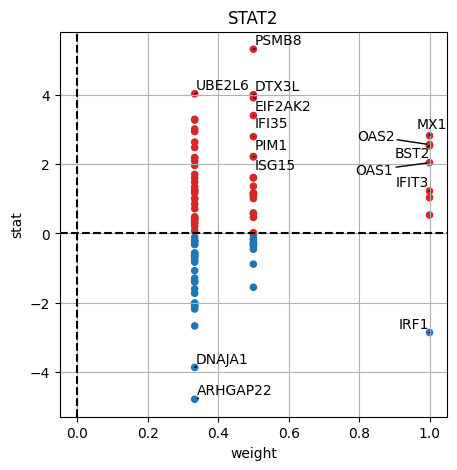

In [27]:
dc.plot_targets(results_df, stat='stat', source_name='STAT2', net=dorothea, top=15)

STAT2 seems to be active in T-cells since their positive targets are up-regulated in COVID-19.

If needed, we can also look at this at the volcano plot:

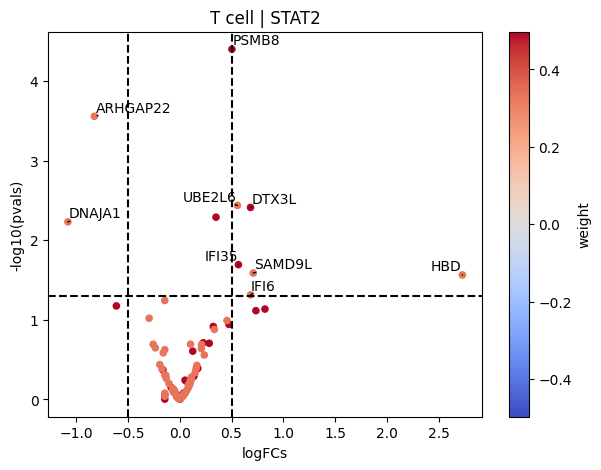

In [28]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'T cell'})
pvals = results_df[['padj']].T.rename(index={'padj': 'T cell'})

# Plot
dc.plot_volcano(logFCs, pvals, 'T cell', name='STAT2', net=dorothea, top=10, sign_thr=0.05, lFCs_thr=0.5)

## Functional enrichment of biological terms
We can also assign the obtained DEG to biological terms using the resource MSigDB. For this example we will use the `ora`
method, but we could have kept using the `consensus`.

For another example on functional enrichment of biological terms please visit this other notebook: [Functional enrichment of biological terms](https://decoupler-py.readthedocs.io/en/latest/notebooks/msigdb.html).

In [29]:
# Retrieve MSigDB resource
msigdb = dc.get_resource('MSigDB')

# Filter by a desired geneset collection, for example hallmarks
msigdb = msigdb[msigdb['collection']=='hallmark']
msigdb = msigdb.drop_duplicates(['geneset', 'genesymbol'])

# Infer enrichment with ora using significant deg
top_genes = results_df[results_df['padj'] < 0.05].reset_index()
top_genes['group'] = 'T cell'
enr_pvals = dc.get_ora_df(top_genes, msigdb, groupby='group', features='gene_symbol', source='geneset', target='genesymbol')
enr_pvals

,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_APOPTOSIS,HALLMARK_COAGULATION,HALLMARK_COMPLEMENT,HALLMARK_DNA_REPAIR,HALLMARK_E2F_TARGETS,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_LATE,...,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_P53_PATHWAY,HALLMARK_PEROXISOME,HALLMARK_PI3K_AKT_MTOR_SIGNALING,HALLMARK_PROTEIN_SECRETION,HALLMARK_SPERMATOGENESIS,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_XENOBIOTIC_METABOLISM
T cell,3.546590e-13,4.644347e-10,7.385748e-18,1.676241e-08,3.546590e-13,2.689267e-16,1.634547e-33,4.644347e-10,1.676241e-08,2.689267e-16,...,1.183113e-36,1.284547e-11,4.644347e-10,4.644347e-10,4.644347e-10,3.546590e-13,8.280691e-29,4.644347e-10,9.774767e-15,4.644347e-10


 We can then transform these p-values to their -log10 (so that the higher the value, the more significant the p-value).
 We will also set 0s to a minimum p-value so that we do not get infinites.

In [30]:
# Set 0s to min p-value
enr_pvals.values[enr_pvals.values == 0] = np.min(enr_pvals.values[enr_pvals.values != 0])

# Log-transform
enr_pvals = -np.log10(enr_pvals)

Then we can visualize the most enriched terms:

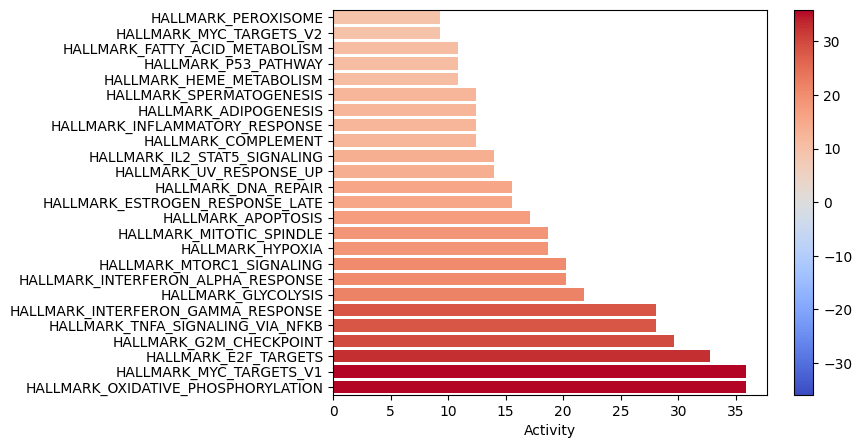

In [31]:
dc.plot_barplot(enr_pvals, 'T cell', top=25, vertical=True)

As before, we can plot the downstream genes of gene sets of interest:

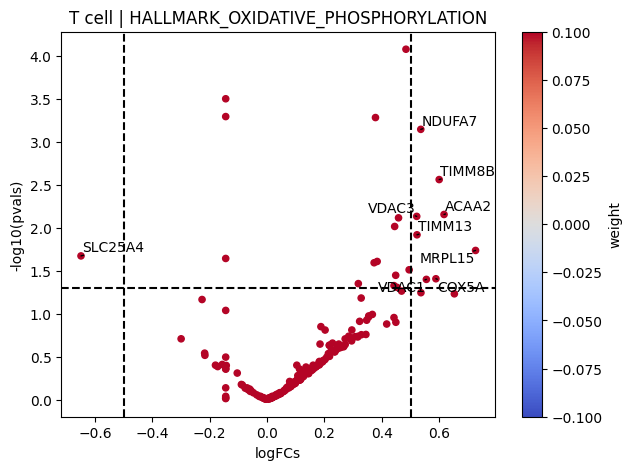

In [32]:
# Plot
dc.plot_volcano(logFCs, pvals, 'T cell', name='HALLMARK_OXIDATIVE_PHOSPHORYLATION', net=msigdb, top=10, sign_thr=0.05, lFCs_thr=0.5, source='geneset', target='genesymbol', weight=None)